In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# import libraries:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))

#from change_of_parameters import omega_CDM_to_luisa, F_H, F_H_prime
from constants import LAMBDA, L, OMEGA_R_0, KAPPA

from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000 #km/s

from getdist import plots
import getdist
from getdist import plots, MCSamples, loadMCSamples
getdist.chains.print_load_details = False
import scipy
from scipy.integrate import simps, solve_ivp
from scipy.linalg import sqrtm
import numpy as np

from seaborn import heatmap
import pandas as pd
import emcee

import time

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_hubble_parameter(z, Hs, model_name='BETA'):
    """
    Plots the Hubble parameter as a function of redshift.

    Parameters:
    z (array-like): Array of redshift values.
    Hs (array-like): Array of Hubble parameter values corresponding to the redshift values.
    model_name (str): Name of the cosmological model used for the plot title.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(z, Hs, label=f'Hubble Parameter ({model_name} Model)', color='blue', linewidth=2)

    # Enhancements
    plt.xlabel('Redshift (z)', fontsize=14)
    plt.ylabel('Hubble Parameter (H(z)) [km/s/Mpc]', fontsize=14)
    plt.title('Hubble Parameter vs Redshift', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.yscale('log')  # Optional: log scale for better visualization
    plt.xscale('log')  # Optional: log scale for better visualization
    plt.minorticks_on()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.tight_layout()

    # Show plot
    plt.show()


def plot_hubble_parameter_subplots(z, Hs, model_name='BETA'):
    """
    Plots the Hubble parameter and the integrand 1/(H(z)*(1+z)) as subplots.

    Parameters:
    z (array-like): Array of redshift values.
    Hs (array-like): Array of Hubble parameter values corresponding to the redshift values.
    model_name (str): Name of the cosmological model used for the plot title.
    """
    # Calculate the integrand
    integrand = 1 / (Hs * (1 + z))

    # Create a DataFrame for Seaborn
    import pandas as pd
    data = pd.DataFrame({'Redshift (z)': z, 'Hubble Parameter (H(z))': Hs, 'Integrand': integrand})

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Hubble parameter
    sns.lineplot(ax=axes[0], data=data, x='Redshift (z)', y='Hubble Parameter (H(z))', label=f'Hubble Parameter ({model_name} Model)', color='blue')
    axes[0].set_xlabel('Redshift (z)', fontsize=14)
    axes[0].set_ylabel('Hubble Parameter (H(z)) [km/s/Mpc]', fontsize=14)
    axes[0].set_title('Hubble Parameter vs Redshift', fontsize=16)
    axes[0].legend(fontsize=12)
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[0].set_yscale('log')  # Optional: log scale for better visualization
    axes[0].set_xscale('log')  # Optional: log scale for better visualization
    axes[0].minorticks_on()
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].tick_params(axis='both', which='minor', labelsize=10)

    # Plot integrand
    sns.lineplot(ax=axes[1], data=data, x='Redshift (z)', y='Integrand', label='Integrand 1/(H(z)*(1+z))', color='green')
    axes[1].set_xlabel('Redshift (z)', fontsize=14)
    axes[1].set_ylabel('Integrand 1/(H(z)*(1+z))', fontsize=14)
    axes[1].set_title('Integrand vs Redshift', fontsize=16)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[1].set_yscale('log')  # Optional: log scale for better visualization
    axes[1].set_xscale('log')  # Optional: log scale for better visualization
    axes[1].minorticks_on()
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].tick_params(axis='both', which='minor', labelsize=10)

    plt.tight_layout()
    plt.show()


In [3]:
#GILA model
def F_H(H, params, model):     
    lamb, L, beta, L_bar, s = params # L and L_bar have to be in units of H0^{-1}
    if model == 'GILA':
        FH = H**2 - H**6 * L_bar**4 * beta * np.exp(-beta*(L_bar*H)**(2*s)) \
                  #+ H**8 * L**6     * lamb * np.exp(lamb*(L*H)**2)
    elif model == 'BETA':
        FH = H**2 - H**2            * beta * np.exp(-beta*(L_bar*H)**(2*s)) \
                  #+ H**8 * L**6 * lamb * np.exp(lamb*(L*H)**4)

    return FH

def F_H_prime(H, params, model):
    lamb, L, beta, L_bar, s = params # L and L_bar have to be in units of H0^{-1}

    if model == 'GILA':
        aux = np.exp(-beta*(L_bar*H)**(2*s)) * beta * (L_bar*H)**4 * (-3 + s * beta * (L_bar*H)**(2*s))
              #np.exp(lamb*(L*H)**2)       * lamb * (L*H)**6     * (4 + lamb*(L*H)**2)
    if model == 'BETA':
        aux = np.exp(-beta*(L_bar*H)**(2*s)) * beta                * (-1 + s * beta * (L_bar*H)**(2*s))
              #2 * np.exp(lamb*(L*H)**4)      * lamb * (L*H)**6  * (2 + lamb*(L*H)**4)

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime


def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    [LAMBDA, L, b, L_bar, H_0, s, model] = params_ode #Here L and L_bar are in units of H0^{-1}

    F_H0 = F_H(H_0, [LAMBDA, L, b, L_bar, s], model)

    omega_m_0 = F_H0 /(100**2) - OMEGA_R_0

    rho_m_0 = 100**2 * omega_m_0 / KAPPA
    rho_r_0 = 100**2 * OMEGA_R_0 / KAPPA
    
    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [LAMBDA, L, b, L_bar, s],model))     
    #print(s)
    return s


def integrator_GILA(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    #L_bar, b, H0 = physical_params
    L_bar, b, H0, s = physical_params
    
    #Cambiar si pasamos de logspace a linspace!
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    
    #ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, model]
    ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, s, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

In [4]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import simps as simps
from scipy.integrate import cumtrapz as cumtrapz
from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000

import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')

from solve_sys import Hubble_th
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L


def omega_CDM_to_luisa(beta, L_bar, H0, Omega_lcdm, s, model):
    factor_inv = H0**2 / F_H(H0, [LAMBDA, L/H0, beta, L_bar/H0, s], model) 
    omega_luisa = Omega_lcdm * factor_inv
    return omega_luisa

def params_to_chi2(theta, dataset_SN_plus_shoes=None,
                   num_z_points=int(10**5), model='GILA'):


    chi2_SN = 0
    [Mabs, L_bar, b, H_0, s] = theta
    physical_params = [L_bar, b, H_0, s]
    try:
        zs_model, Hs_model = integrator_GILA(physical_params, model=model, num_z_points=num_z_points,
                                            initial_z=0, final_z=10)
    except Exception as e:
        # If integration fails, reject the step
        return -np.inf

    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interp = interp1d(zs_model, int_inv_Hs)

    if dataset_SN_plus_shoes != None:
        zhd, zhel, mb, mu_shoes, Cinv, is_cal = dataset_SN_plus_shoes #Import the data
        muobs = mb - Mabs
        muth_num = aparent_magnitude_th(int_inv_Hs_interp, zhd, zhel) #Numeric prediction of mu
        muth = muth_num*(-is_cal + 1) + mu_shoes*(is_cal) #Merge num predicion with mu_shoes
        chi2_SN = chi2_supernovae(muth, muobs, Cinv)


    return chi2_SN

def log_likelihood(*args, **kargs):  
    '''
    Return the log likelihood in terms of the chi square.
    '''
    return -0.5 * params_to_chi2(*args, **kargs)


path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from data import read_data_pantheon_plus_shoes

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
ds_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                'Pantheon+SH0ES_STAT+SYS.cov')



In [5]:
omega_r = 2.47e-5 
L_bar = 0.90
M_abs = -19.3

Gyr_to_second = int(3.1536e16)
Mpc_to_km = int(3.0857e19)
inv_Hub_to_Gyr = Mpc_to_km/Gyr_to_second

z = np.linspace(0, 1000, int(10e3))



In [6]:
import seaborn as sns

#LCDM MODEL
#M_abs = flat_samples_lcdm[:,0]
omega_m = 0.16290042980084599
H0 = 72.18797371868

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm
#aou_lcdm = np.zeros(len(H0))

Hubble = H0 * np.sqrt(Omega_r_lcdm * (1+z)**4 + Omega_m_lcdm * (1+z)**3 + Omega_L_lcdm )
integrand_LCDM = 1 / (Hubble * (1 + z))
aou_lcdm = inv_Hub_to_Gyr * simps(((1+z) * Hubble)**(-1), z)   


print('Aou LCDM best fit={:2f} Gyr'.format(aou_lcdm))

aou_threshold = 12.7

Aou LCDM best fit=12.916077 Gyr


In [16]:
H0 = 65

s=2,beta=1,chi2=2.56294498043766
s=2,beta=2,chi2=3.2832713664423028
s=3,beta=1,chi2=3.1953638026863227
s=3,beta=2,chi2=4.429085973573782
s=3,beta=3,chi2=4.270868775013497
s=3,beta=4,chi2=3.662016850614968
s=4,beta=1,chi2=3.708415072850157
s=4,beta=2,chi2=5.390040578707438
s=4,beta=3,chi2=5.486149405931081
s=4,beta=4,chi2=5.117271331823398
s=4,beta=5,chi2=4.519049445876105
s=4,beta=6,chi2=3.8046355367420914
s=5,beta=1,chi2=4.114260298883132
s=5,beta=2,chi2=6.180437335230252
s=5,beta=4,chi2=6.180284845075693
s=5,beta=5,chi2=5.868285015412678
s=5,beta=6,chi2=5.436054205987257
s=5,beta=7,chi2=4.870611314357587
s=5,beta=8,chi2=4.212668274966178
s=6,beta=1,chi2=4.431962988460901
s=6,beta=7,chi2=6.153024303295853
s=6,beta=8,chi2=5.845630671062318
s=6,beta=9,chi2=5.4404635678904585
s=6,beta=10,chi2=4.918897582316078
s=7,beta=1,chi2=4.681577197083912
s=8,beta=0.5,chi2=2.4185627896070545
s=8,beta=1,chi2=4.8797094566936785
s=9,beta=0.5,chi2=2.4679733347437476
s=9,beta=1,chi2=5.038455733816359
s=1

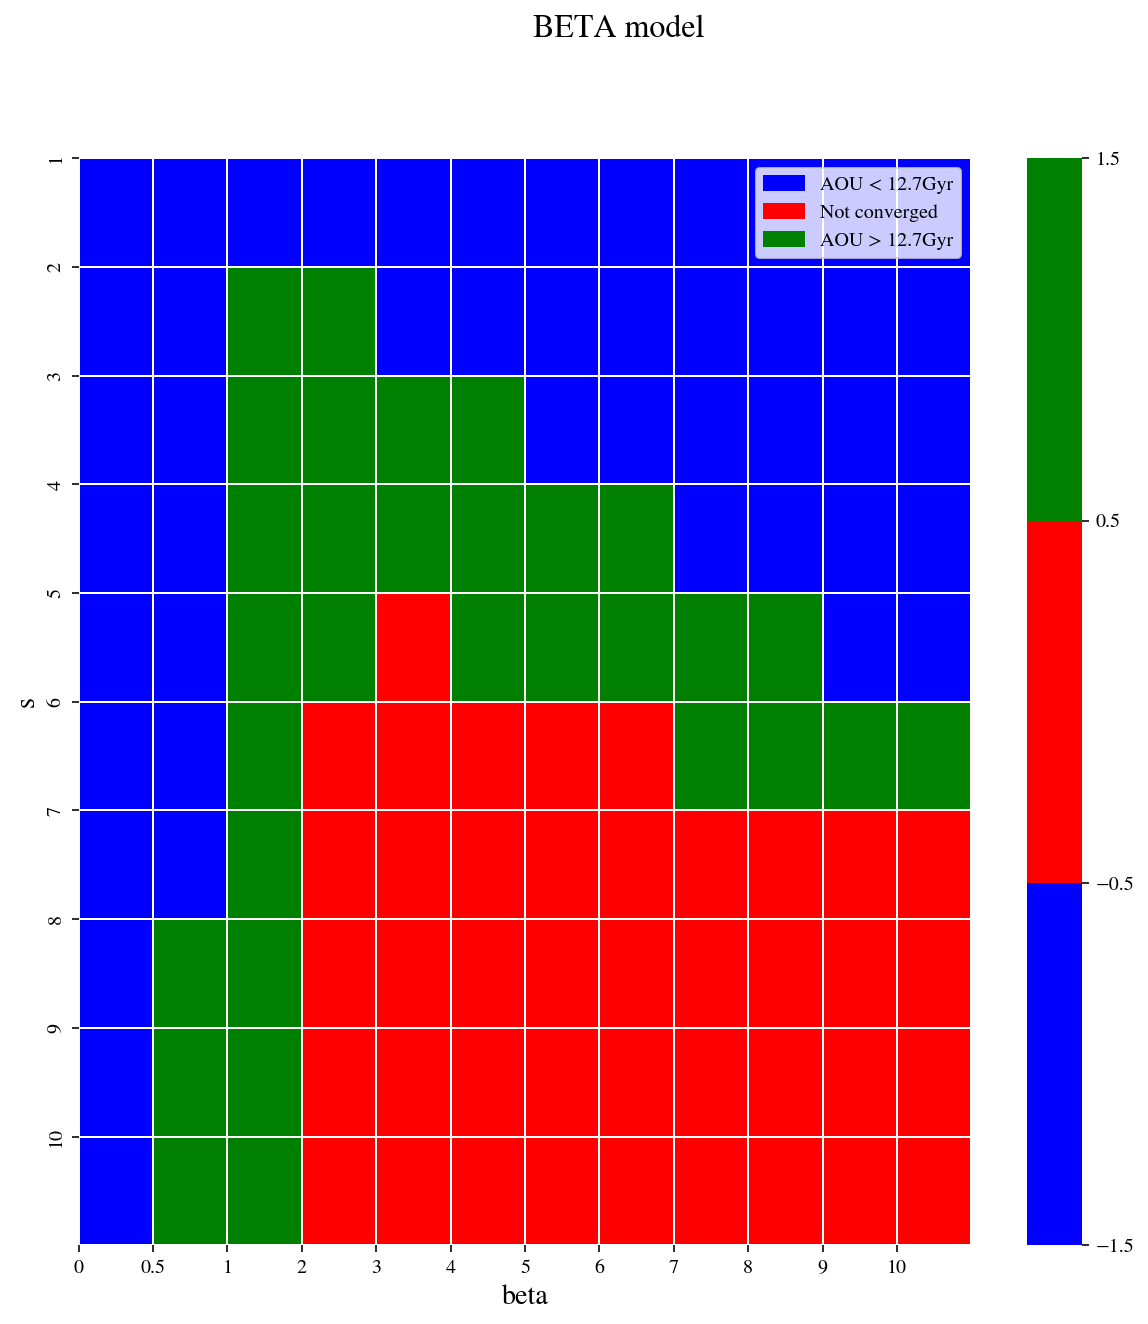

In [17]:
#BETA MODEL
s_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
beta_values = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#beta_values = [1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('BETA model', fontsize=16) 

matrix = np.zeros((len(s_values), len(beta_values)))

for i, s_val in enumerate(s_values):
    for j, beta_val in enumerate(beta_values):
        physical_params = [L_bar, beta_val, H0, s_val]
        try :        
            z_final, Hs_final = integrator_GILA(physical_params, model='BETA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1])
        except Exception as e:
            # If integration fails
            matrix[i, j] = 0
            continue
        aou_beta = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)
        if aou_beta < aou_threshold:
            matrix[i, j] = -1
        else:
            matrix[i, j] = 1
            theta = [M_abs, L_bar, beta_val, H0, s_val]
            print('s={},beta={},chi2={}'.format(s_val, beta_val, params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, model='BETA')/(ds_SN_plus_shoes[2].shape[0]-3)))
# Create a discrete colormap
cmap = matplotlib.colors.ListedColormap(['blue', 'red', 'green'])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the heatmap with discrete colormap
ax = sns.heatmap(matrix, linewidth=0.5, cmap=cmap, norm=norm)
ax.set_xlabel('beta', fontsize=14)
ax.set_ylabel('s', fontsize=14)
ax.set_xticks(np.arange(len(beta_values)))
ax.set_yticks(np.arange(len(s_values)))
ax.set_xticklabels(beta_values)
ax.set_yticklabels(s_values)
legend_handles = [matplotlib.patches.Patch(color='blue', label='AOU < LCDM'),
                  matplotlib.patches.Patch(color='red', label='AOU = LCDM'),
                  matplotlib.patches.Patch(color='green', label='AOU > LCDM')]
legend_labels = ['AOU < 12.7Gyr', 'Not converged', 'AOU > 12.7Gyr']
ax.legend(handles=legend_handles, labels=legend_labels, loc='upper right')
ax.label_outer()
fig.savefig(os.path.join(path_figures, 'heat_map_aou_BETA_H0={:3g}.png'.format(H0)))
plt.show()

s=3,beta=2,chi2=2.5489913332146967
s=4,beta=2,chi2=3.2806701996668104
s=4,beta=3,chi2=3.693232674856591
s=4,beta=4,chi2=3.5252461105570014
s=5,beta=1,chi2=2.043096726176735
s=5,beta=2,chi2=3.929762577555455
s=5,beta=3,chi2=4.617726795842951
s=5,beta=4,chi2=4.653811970836781
s=5,beta=5,chi2=4.387575162993579
s=5,beta=6,chi2=3.961654761599971
s=6,beta=1,chi2=2.2415423666941208
s=6,beta=2,chi2=4.4696484902176365
s=6,beta=3,chi2=5.40395414419929
s=6,beta=4,chi2=5.601489880996201
s=6,beta=5,chi2=5.511149293156585
s=6,beta=6,chi2=5.284562975782213
s=6,beta=7,chi2=4.944350775671886
s=6,beta=8,chi2=4.514868532121451
s=6,beta=9,chi2=4.034275100173767
s=7,beta=1,chi2=2.380285982067682
s=7,beta=2,chi2=4.920574362967939
s=7,beta=3,chi2=6.145731254263565
s=7,beta=6,chi2=6.1968636497349925
s=7,beta=7,chi2=6.038753508141994
s=7,beta=8,chi2=5.82291698685388
s=7,beta=9,chi2=5.564959208091312
s=7,beta=10,chi2=5.237848106229261
s=8,beta=1,chi2=2.4648664216966765
s=8,beta=2,chi2=5.330306390559336
s=9,beta

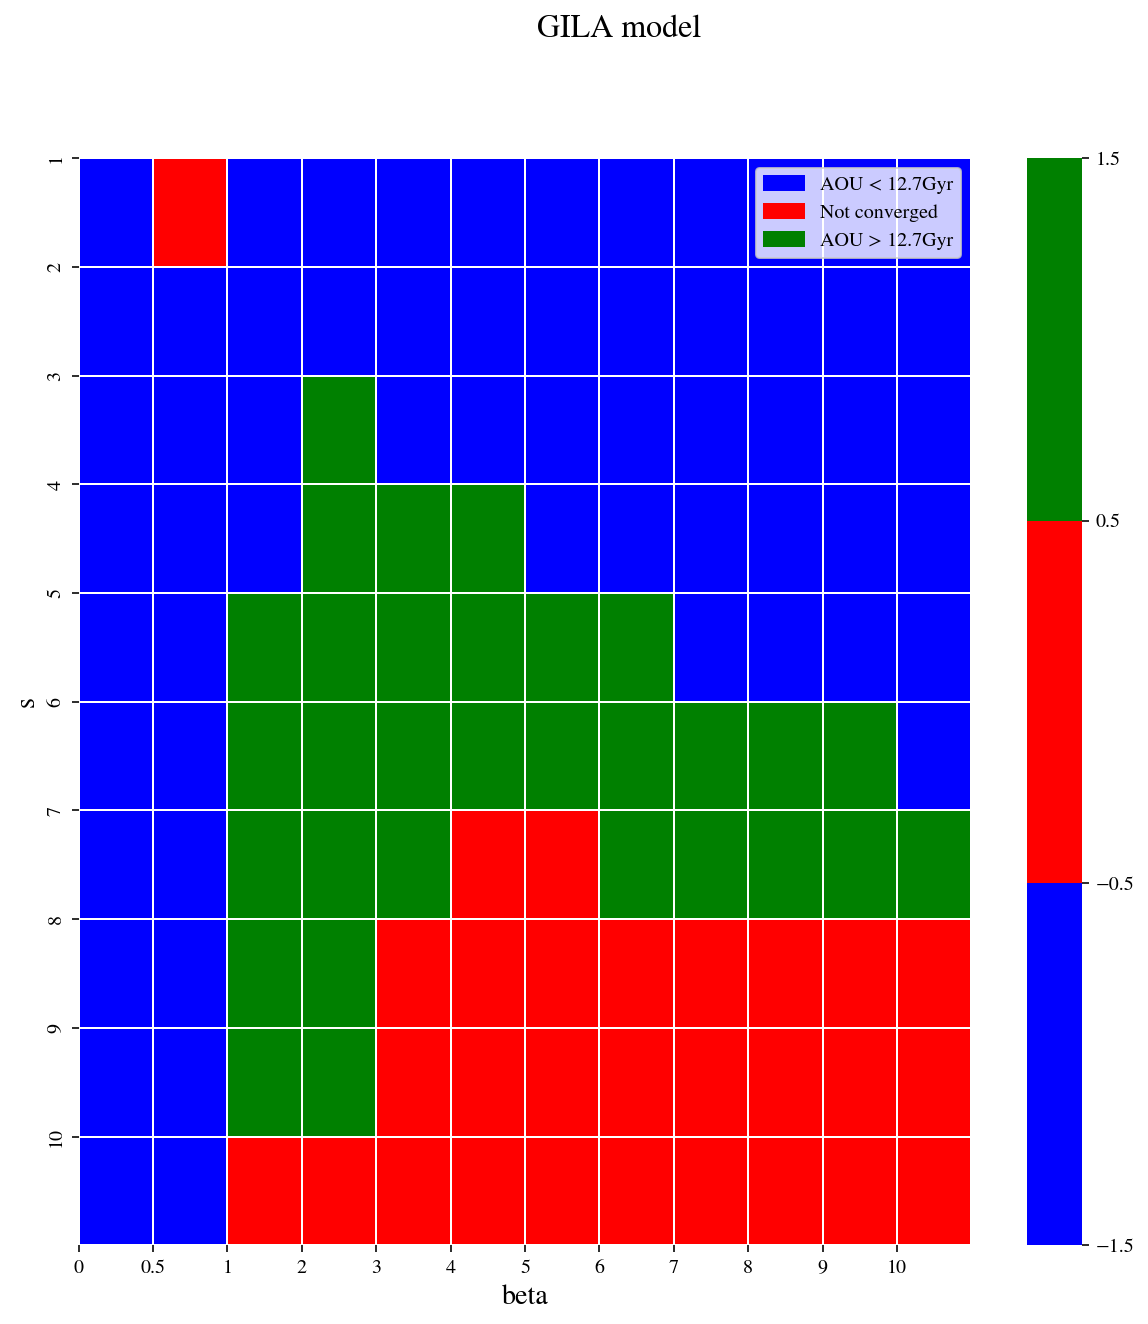

In [18]:
#GILA MODEL
s_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
beta_values = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#beta_values = [1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('GILA model', fontsize=16) 

matrix = np.zeros((len(s_values), len(beta_values)))

for i, s_val in enumerate(s_values):
    for j, beta_val in enumerate(beta_values):
        physical_params = [L_bar, beta_val, H0, s_val]
        try :        
            z_final, Hs_final = integrator_GILA(physical_params, model='GILA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1])
        except Exception as e:
            # If integration fails
            matrix[i, j] = 0
            continue
        
        aou_gila = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)
        if aou_gila < aou_threshold:
            matrix[i, j] = -1
        else:
            matrix[i, j] = 1
            theta = [M_abs, L_bar, beta_val, H0, s_val]
            #print('s={},beta={},chi2={}'.format(s_val, beta_val, params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, model='GILA')))
            print('s={},beta={},chi2={}'.format(s_val, beta_val, params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, model='GILA')/(ds_SN_plus_shoes[2].shape[0]-3)))
# Create a discrete colormap
cmap = matplotlib.colors.ListedColormap(['blue', 'red', 'green'])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the heatmap with discrete colormap
ax = sns.heatmap(matrix, linewidth=0.5, cmap=cmap, norm=norm)
ax.set_xlabel('beta', fontsize=14)
ax.set_ylabel('s', fontsize=14)
ax.set_xticks(np.arange(len(beta_values)))
ax.set_yticks(np.arange(len(s_values)))
ax.set_xticklabels(beta_values)
ax.set_yticklabels(s_values)
legend_handles = [matplotlib.patches.Patch(color='blue', label='AOU < LCDM'),
                  matplotlib.patches.Patch(color='red', label='AOU = LCDM'),
                  matplotlib.patches.Patch(color='green', label='AOU > LCDM')]
legend_labels = ['AOU < 12.7Gyr', 'Not converged', 'AOU > 12.7Gyr']
ax.legend(handles=legend_handles, labels=legend_labels, loc='upper right')
ax.label_outer()
fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_H0={:3g}.png'.format(H0)))
plt.show()